In [1]:
## Install the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder, MinMaxScaler

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
# Load data
data = pd.read_csv("/content/Customer_Data.csv")

In [5]:
data.shape

(6418, 32)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6418 entries, 0 to 6417
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer_ID                  6418 non-null   object 
 1   Gender                       6418 non-null   object 
 2   Age                          6418 non-null   int64  
 3   Married                      6418 non-null   object 
 4   State                        6418 non-null   object 
 5   Number_of_Referrals          6418 non-null   int64  
 6   Tenure_in_Months             6418 non-null   int64  
 7   Value_Deal                   2870 non-null   object 
 8   Phone_Service                6418 non-null   object 
 9   Multiple_Lines               5796 non-null   object 
 10  Internet_Service             6418 non-null   object 
 11  Internet_Type                5028 non-null   object 
 12  Online_Security              5028 non-null   object 
 13  Online_Backup     

In [7]:
data.describe()

,Age,Number_of_Referrals,Tenure_in_Months,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue
count,6418.000000,6418.000000,6418.000000,6418.000000,6418.000000,6418.000000,6418.000000,6418.000000,6418.000000
mean,47.070739,7.427859,17.342786,63.652867,2280.374858,1.924944,6.718604,748.703468,3033.871987
std,16.703633,4.621519,10.576391,31.188823,2268.049985,7.849083,24.722533,847.672844,2866.505426
min,18.000000,0.000000,1.000000,-10.000000,18.800000,0.000000,0.000000,0.000000,21.360000
25%,33.000000,3.000000,8.000000,30.562500,395.725000,0.000000,0.000000,70.805000,603.742500
50%,46.000000,7.000000,16.000000,70.100000,1396.125000,0.000000,0.000000,407.475000,2108.635000
75%,60.000000,11.000000,27.000000,89.750000,3783.600000,0.000000,0.000000,1182.917500,4801.537500
max,85.000000,15.000000,36.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000


In [8]:
min_positive = data[data['Monthly_Charge'] > 0]['Monthly_Charge'].min()

# Replace negative values with the minimum positive value
data['Monthly_Charge'] = data['Monthly_Charge'].apply(lambda x: min_positive if x < 0 else x)

data['Multiple_Lines'] = data['Multiple_Lines'].fillna(data['Multiple_Lines'].mode()[0])

In [9]:
data.duplicated().sum()

0

In [10]:
# Drop the join related data
data = data[data['Customer_Status'] != 'Joined']

In [11]:
(data.isnull().sum()/ len(data))*100

,0
Customer_ID,0.000000
Gender,0.000000
Age,0.000000
Married,0.000000
State,0.000000
Number_of_Referrals,0.000000
Tenure_in_Months,0.000000
Value_Deal,54.885966
Phone_Service,0.000000
Multiple_Lines,0.000000


In [12]:
# Drop unrelated data and value deal --> 55% null value
data = data.drop(['Customer_ID', 'Churn_Category', 'Churn_Reason','Value_Deal'], axis=1)

In [13]:
data['Internet_Service'].value_counts()

,count
Internet_Service,
Yes,4784
No,1223


In [14]:
filtered_data = data[(data['Internet_Service'] == "No") & (data['Customer_Status'] == "Churned")]

In [15]:
len(filtered_data)

109

In [16]:
# Drop null value (because 20%)
data = data.dropna(subset=['Internet_Type'])

In [17]:
data['Internet_Service'].value_counts()

,count
Internet_Service,
Yes,4784


In [18]:
# Only "Yes"
data = data.drop(['Internet_Service'], axis=1)

In [19]:
# find Outlier
def find_outliers_iqr(df, numeric_columns):

    outlier_summary = {}

    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)  # First Quartile (25%)
        Q3 = df[column].quantile(0.75)  # Third Quartile (75%)
        IQR = Q3 - Q1                   # Interquartile Range

        lower_bound = Q1 - 1.5 * IQR    # Lower fence
        upper_bound = Q3 + 1.5 * IQR    # Upper fence

        # Find outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        # Save the count of outliers
        outlier_summary[column] = len(outliers)

    # Convert results to DataFrame
    outlier_summary_df = pd.DataFrame(outlier_summary.items(), columns=['Column', 'Outlier_Count'])
    return outlier_summary_df


In [20]:
numeric_columns = ['Age', 'Number_of_Referrals', 'Tenure_in_Months', 'Monthly_Charge',
                   'Total_Charges', 'Total_Refunds', 'Total_Extra_Data_Charges',
                   'Total_Long_Distance_Charges', 'Total_Revenue']
outlier_counts = find_outliers_iqr(data, numeric_columns)
print(outlier_counts)

                        Column  Outlier_Count
0                          Age              0
1          Number_of_Referrals              0
2             Tenure_in_Months              0
3               Monthly_Charge              0
4                Total_Charges              0
5                Total_Refunds            378
6     Total_Extra_Data_Charges            614
7  Total_Long_Distance_Charges            116
8                Total_Revenue              0


In [21]:
data['Total_Extra_Data_Charges'].describe()

,Total_Extra_Data_Charges
count,4784.000000
mean,8.808528
std,28.190270
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,150.000000


In [22]:
a = data[data['Total_Extra_Data_Charges'] == 0]
print(len(a))

4170


In [23]:
data['Total_Refunds'].describe()

,Total_Refunds
count,4784.000000
mean,2.082149
std,8.150290
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,49.570000


In [24]:
b = data[data['Total_Refunds'] == 0]
len(b)

4406

In [25]:
data['Total_Long_Distance_Charges'].describe()

,Total_Long_Distance_Charges
count,4784.000000
mean,777.278806
std,862.737275
min,0.000000
25%,80.122500
50%,429.700000
75%,1238.397500
max,3536.640000


In [26]:
# Total_Extra_Data_Charges and Total_Refunds
# most value are zero
data = data.drop(['Total_Extra_Data_Charges','Total_Refunds'], axis=1)

In [27]:
def handle_outliers(data, columns):

    for col in columns:
        # Calculate IQR
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Capping the outliers
        data[col] = data[col].clip(lower_bound, upper_bound)

    return data

# Columns with outliers
columns_to_treat = ['Total_Long_Distance_Charges']

# Apply the function
data = handle_outliers(data, columns_to_treat)

In [28]:
data.columns

Index(['Gender', 'Age', 'Married', 'State', 'Number_of_Referrals',
       'Tenure_in_Months', 'Phone_Service', 'Multiple_Lines', 'Internet_Type',
       'Online_Security', 'Online_Backup', 'Device_Protection_Plan',
       'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
       'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
       'Payment_Method', 'Monthly_Charge', 'Total_Charges',
       'Total_Long_Distance_Charges', 'Total_Revenue', 'Customer_Status'],
      dtype='object')

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4784 entries, 0 to 6417
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Gender                       4784 non-null   object 
 1   Age                          4784 non-null   int64  
 2   Married                      4784 non-null   object 
 3   State                        4784 non-null   object 
 4   Number_of_Referrals          4784 non-null   int64  
 5   Tenure_in_Months             4784 non-null   int64  
 6   Phone_Service                4784 non-null   object 
 7   Multiple_Lines               4784 non-null   object 
 8   Internet_Type                4784 non-null   object 
 9   Online_Security              4784 non-null   object 
 10  Online_Backup                4784 non-null   object 
 11  Device_Protection_Plan       4784 non-null   object 
 12  Premium_Support              4784 non-null   object 
 13  Streaming_TV           

In [30]:
numeric_columns= ['Age','Number_of_Referrals','Tenure_in_Months','Monthly_Charge','Total_Charges','Total_Long_Distance_Charges','Total_Revenue']

In [31]:
sns.set(style="whitegrid")
custom_palette = sns.color_palette(["#81c784", "#388e3c"])

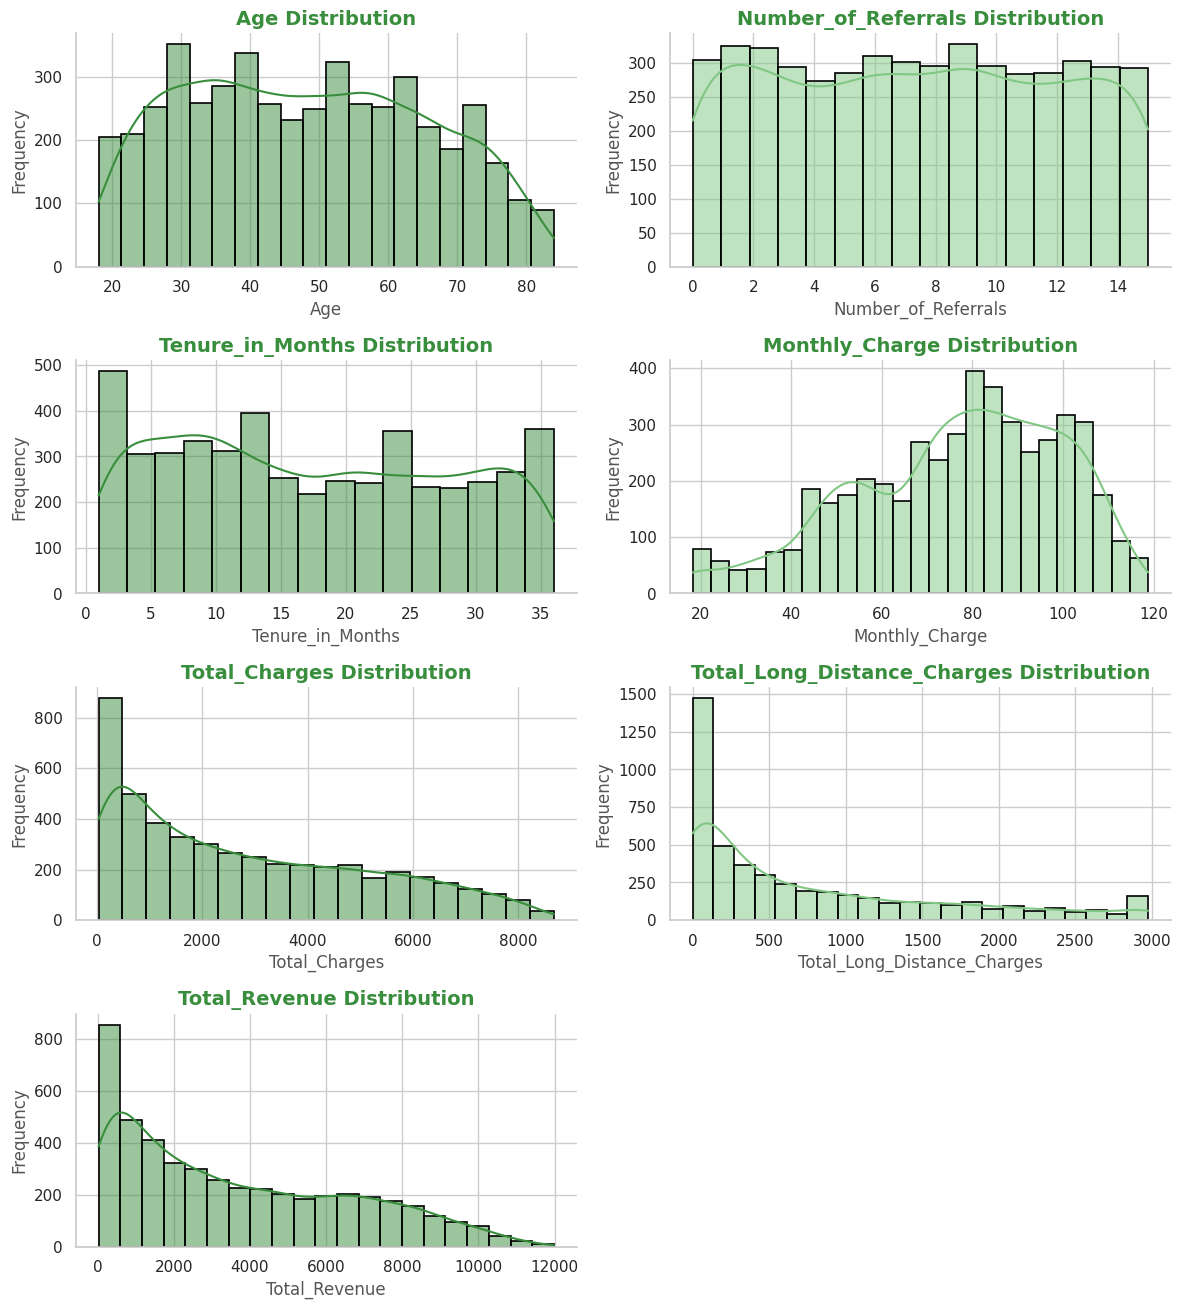

In [32]:
# Histograms for Numerical Features
plt.figure(figsize=(12, 16))

for idx, col in enumerate(numeric_columns, 1):
    plt.subplot(5, 2, idx)
    sns.histplot(data[col], kde=True, color=custom_palette[idx % 2], edgecolor="black", linewidth=1.2)

    plt.title(f'{col} Distribution', fontsize=14, weight='bold', color="#388e3c")
    plt.xlabel(col, fontsize=12, color="#555555")
    plt.ylabel('Frequency', fontsize=12, color="#555555")

    sns.despine()

plt.tight_layout()
plt.show()

In [33]:
right_skew_col= ['Total_Charges','Total_Long_Distance_Charges','Total_Revenue']

In [34]:
# Log transformation for skewed data
for col in right_skew_col:
  data[col] = np.log1p(data[col])

In [35]:
data.head()

,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Phone_Service,Multiple_Lines,Internet_Type,Online_Security,...,Streaming_Music,Unlimited_Data,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status
0,Male,35,No,Delhi,7,27,Yes,No,Cable,No,...,No,Yes,One Year,Yes,Credit Card,65.60,6.387384,5.946755,6.883268,Stayed
1,Female,45,Yes,Maharashtra,14,13,Yes,Yes,Cable,No,...,Yes,No,Month-to-Month,No,Credit Card,18.25,6.297846,4.576874,6.415555,Stayed
2,Male,51,No,West Bengal,4,35,Yes,No,Fiber Optic,No,...,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.90,5.641375,4.909709,6.031766,Churned
3,Male,79,No,Karnataka,3,21,Yes,No,Fiber Optic,No,...,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.00,7.121939,5.893466,7.378078,Churned
4,Female,80,No,Tamil Nadu,3,8,Yes,No,Fiber Optic,No,...,No,Yes,Month-to-Month,Yes,Credit Card,83.90,5.592478,3.141563,5.671741,Churned


In [36]:
data.isnull().sum()

,0
Gender,0
Age,0
Married,0
State,0
Number_of_Referrals,0
Tenure_in_Months,0
Phone_Service,0
Multiple_Lines,0
Internet_Type,0
Online_Security,0


In [37]:
#Encode for categorical features

In [38]:
#Target column
data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})

In [39]:
# Encode all other categorical features (binary values) except 'State'
categorical_columns = ['Gender', 'Married', 'Phone_Service', 'Multiple_Lines', 'Internet_Type', 'Online_Security',
                       'Online_Backup','Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
                       'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing','Payment_Method']

In [40]:
# Label Encoding for all categorical columns except 'State'

label_encoders = {}  # Save the LabelEncoder for each categorical column
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])  # Fit to the original data
    label_encoders[col] = le
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

In [41]:
# onehotencoder for ordinal data
data['State'] = data['State'].str.strip()

# Initialize the encoder
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Drop first to avoid dummy variable trap

# Fit and transform the 'State' column
encoded_state = encoder.fit_transform(data[['State']])
# Save the OneHotEncoder for 'State'
joblib.dump(encoder, 'onehot_encoder.pkl')

# Convert the result to a DataFrame
encoded_state_df = pd.DataFrame(encoded_state, columns=encoder.get_feature_names_out(['State']))

# Concatenate the encoded DataFrame back to the original dataset
data = pd.concat([data.reset_index(drop=True).drop('State', axis=1), encoded_state_df.reset_index(drop=True)], axis=1)

In [42]:
# Assign X and y value
X = data.drop('Customer_Status', axis=1)
y = data['Customer_Status']

In [43]:
#The dataset is imbalanced

# Over Sampling

In [44]:
#implement SMOTE.

In [45]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [46]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

In [47]:
# Scaling numeric features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the MinMaxScaler
joblib.dump(scaler, 'minmax_scaler.pkl')

['minmax_scaler.pkl']

In [48]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier()
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy for {model_name}: {accuracy}")
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred))
    print(f"Confusion Matrix for {model_name}:\n", confusion_matrix(y_test, y_pred))
    print("-"*50)


Accuracy for Logistic Regression: 0.8237154150197629
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.81      0.82      0.82       614
           1       0.83      0.82      0.83       651

    accuracy                           0.82      1265
   macro avg       0.82      0.82      0.82      1265
weighted avg       0.82      0.82      0.82      1265

Confusion Matrix for Logistic Regression:
 [[506 108]
 [115 536]]
--------------------------------------------------
Accuracy for Decision Tree: 0.7865612648221344
Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79       614
           1       0.81      0.77      0.79       651

    accuracy                           0.79      1265
   macro avg       0.79      0.79      0.79      1265
weighted avg       0.79      0.79      0.79      1265

Confusion Matrix for Decision Tree:
 [[

In [49]:
# parameter Tunnig for Gradient Boosting Classifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Define the model
gbc = GradientBoostingClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
Best Accuracy: 0.8680993263821286


In [50]:
best_gbc = GradientBoostingClassifier(
    learning_rate=0.2,
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=150,
    random_state=42
)

# Train on the full training dataset
best_gbc.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.2, min_samples_split=10,
                           n_estimators=150, random_state=42)

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred = best_gbc.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       614
           1       0.89      0.82      0.85       651

    accuracy                           0.85      1265
   macro avg       0.85      0.85      0.85      1265
weighted avg       0.85      0.85      0.85      1265

Confusion Matrix:
[[546  68]
 [120 531]]


In [56]:
# Save the trained GradientBoostingClassifier
joblib.dump(best_gbc, 'gradient_boosting_model.pkl')

['gradient_boosting_model.pkl']

In [57]:
# Load the saved model and preprocessing objects
loaded_model = joblib.load('gradient_boosting_model.pkl')
loaded_scaler = joblib.load('minmax_scaler.pkl')
loaded_label_encoders = joblib.load('label_encoders.pkl')
loaded_onehot_encoder = joblib.load('onehot_encoder.pkl')


In [58]:
# Load saved model and preprocessing objects
loaded_model = joblib.load('gradient_boosting_model.pkl')  # Model
loaded_scaler = joblib.load('minmax_scaler.pkl')  # Scaler
loaded_label_encoders = joblib.load('label_encoders.pkl')  # Dictionary of label encoders
loaded_onehot_encoder = joblib.load('onehot_encoder.pkl')  # OneHotEncoder for categorical features

# Sample new data (replace with actual new data)
new_data = pd.DataFrame({
    'Gender': ['Male', 'Female'],
    'Age': [34, 45],
    'Married': ['Yes', 'No'],
    'Number_of_Referrals': [2, 1],
    'Tenure_in_Months': [12, 24],
    'Phone_Service': ['Yes', 'Yes'],
    'Multiple_Lines': ['No', 'Yes'],
    'Internet_Type': ['DSL', 'Fiber Optic'],
    'Online_Security': ['Yes', 'No'],
    'Online_Backup': ['No', 'Yes'],
    'Device_Protection_Plan': ['No', 'Yes'],
    'Premium_Support': ['Yes', 'No'],
    'Streaming_TV': ['No', 'Yes'],
    'Streaming_Movies': ['No', 'No'],
    'Streaming_Music': ['Yes', 'Yes'],
    'Unlimited_Data': ['Yes', 'No'],
    'Contract': ['Month-to-Month', 'Two Year'],
    'Paperless_Billing': ['Yes', 'Yes'],
    'Payment_Method': ['Bank Withdrawal', 'Credit Card'],
    'Monthly_Charge': [75.5, 105.3],
    'Total_Charges': [900.0, 2527.2],
    'Total_Refunds': [0.0, 0.0],
    'Total_Extra_Data_Charges': [10.0, 5.0],
    'Total_Long_Distance_Charges': [15.0, 25.0],
    'Total_Revenue': [925.0, 2557.2],
    'State': ['Karnataka', 'Kerala']
})

# Step 1: Apply label encoding to categorical columns
for col, le in loaded_label_encoders.items():
    if col in new_data.columns:
        new_data[col] = le.transform(new_data[col])

# Step 2: Apply one-hot encoding to the 'State' column
state_encoded = loaded_onehot_encoder.transform(new_data[['State']])
state_encoded_df = pd.DataFrame(state_encoded, columns=loaded_onehot_encoder.get_feature_names_out(['State']))
new_data = pd.concat([new_data.drop('State', axis=1), state_encoded_df], axis=1)

# Step 3: Ensure all features required by the scaler are present
for feature in loaded_scaler.feature_names_in_:
    if feature not in new_data.columns:
        new_data[feature] = 0  # Add missing columns with default values

# Reorder columns to match scaler input
new_data = new_data[loaded_scaler.feature_names_in_]

# Step 4: Scale the data
scaled_data = loaded_scaler.transform(new_data)

# Step 5: Make predictions
predictions = loaded_model.predict(scaled_data)

# Step 6: Get prediction probabilities (optional)
prediction_probs = loaded_model.predict_proba(scaled_data)

# Display predictions
for i, (pred, prob) in enumerate(zip(predictions, prediction_probs)):
    print(f"Customer {i+1}: Predicted Class = {pred}, Probabilities = {prob}")


Customer 1: Predicted Class = 0, Probabilities = [0.81976621 0.18023379]
Customer 2: Predicted Class = 0, Probabilities = [0.98522591 0.01477409]


# Under Sampling

In [52]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)

In [53]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2, random_state=42)

In [54]:
# Scaling numeric features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [55]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier()
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    tran = model.predict(X_train)
    train = accuracy_score(y_train,tran)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy for {model_name}: {accuracy}")
    print(f"train Accuracy for {model_name}: {train}")
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred))
    print(f"Confusion Matrix for {model_name}:\n", confusion_matrix(y_test, y_pred))
    print("-"*50)


Accuracy for Logistic Regression: 0.7876923076923077
train Accuracy for Logistic Regression: 0.7939137134052389
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.85      0.75      0.80       366
           1       0.72      0.83      0.77       284

    accuracy                           0.79       650
   macro avg       0.79      0.79      0.79       650
weighted avg       0.80      0.79      0.79       650

Confusion Matrix for Logistic Regression:
 [[275  91]
 [ 47 237]]
--------------------------------------------------
Accuracy for Decision Tree: 0.7461538461538462
train Accuracy for Decision Tree: 1.0
Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.79      0.74      0.77       366
           1       0.69      0.75      0.72       284

    accuracy                           0.75       650
   macro avg       0.74      0.75      0.74       6